In [201]:
import os
import os.path as osp
from ipywidgets import interact

import numpy as np
import pandas as pd
import clip
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm import tqdm

import EmotionPredictor.data_tools as dt
from EmotionPredictor import evaluation
from EmotionPredictor.evaluation import Report
from EmotionPredictor.visual import show_torch_image

%config InlineBackend.figure_format ='retina'

In [128]:
ARTEMIS_EMOTIONS = ['amusement',
 'awe',
 'contentment',
 'excitement',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'something else']

In [130]:
preprocessed_img_folder = "../_data/preprocessed/"
preprocessed_img_folder = osp.join(preprocessed_img_folder, "img_size_224")

## Colect results of every model

In [212]:
test_results_path = "../results/test_results/"
# Clip & Imagenet
for name in os.listdir(test_results_path):
    report = Report(class_labels=ARTEMIS_EMOTIONS)
    report.load_labels_results(osp.join(test_results_path, name))
    reports[name] = report

# zero shot
# Raw images
# Imagenet 
# Imagenet + Artemis
resnet_results = np.load("../results/Artemis_training/trained_resnet_results", allow_pickle=True)
resnet_labels = report.labels
reports["ArtEmis"] = Report(resnet_results, resnet_labels, ARTEMIS_EMOTIONS, 0.5)





In [58]:
keys_ordered = list(reports.keys())
keys_ordered.sort()
@interact(model = keys_ordered , threshold = (0.5, 1, 0.05))
def show_reports(model, threshold):
    reports[model].threshold = threshold
    reports[model].show_results(model)

interactive(children=(Dropdown(description='model', options=('ArtEmis', 'C-RN101', 'C-RN50', 'C-RN50x16', 'C-R…

# Overall metrics comparison

In [293]:
@interact(threshold = (0.5, 1, 0.05))
def overall_metrics(threshold):
    overall = []
    
    for name, model in reports.items():
        model.threshold = threshold
        overall.append([name, model.overall_metrics()])
    keys, values = zip(*overall)
    df_overall = pd.concat(values, axis = 1)
    df_overall.columns = keys
    fig = px.bar(df_overall[keys_ordered], barmode = "group", height = 500)
    #fig.update_layout(transition_duration = 1500)
    return fig

interactive(children=(FloatSlider(value=0.75, description='threshold', max=1.0, min=0.5, step=0.05), Output())…

# Paintings maximising an emotion

In [131]:
image_loader = dt.Pickle_data_loader(osp.join(preprocessed_img_folder, "test"))
emotion2index = dict(zip(ARTEMIS_EMOTIONS, range(9)))

In [300]:

@torch.no_grad()
@interact(model = keys_ordered, emotion = ARTEMIS_EMOTIONS, relative = True, n = (2,5,1))
def paintings_maximising_emotions(relative, emotion, model, n):

    fig, axs = plt.subplots(1, n, figsize=(16,9))
    model = reports[model]
    res = model.results

    res_sf = torch.tensor(res).softmax(1).numpy()
    max_emotions_paintings = {}
    if relative: 
        id_max = np.argsort(res_sf[:,emotion2index[emotion]])[-n:]
    else : 
        id_max = np.argsort(res[:,emotion2index[emotion]])[-n:]
        
    for i, index in enumerate(id_max):
        axis = axs[i]
        if i == 0 :axis.title.set_text(f"{emotion.capitalize()}: {round(res_sf[index, emotion2index[emotion]]*100)}%")
        else : axis.title.set_text(f"{round(res_sf[index, emotion2index[emotion]]*100)}%")
        show_torch_image(image_loader.load_label(index, 40)["image"], axis = axis)
        axis.set_ylabel(emotion.capitalize())

    #save_fig(f"../results/clip_training/{model}/maxed_{emotion}.pdf")
#

interactive(children=(Checkbox(value=True, description='relative'), Dropdown(description='emotion', options=('…

In [ ]:
#def paintings_maximising_emotions(relative, emotion, model, n):
#
#    fig, axs = plt.subplots(1, n, figsize=(16,9))
#    model = reports[model]
#    res = model.results
#    if relative :
#        res = torch.tensor(res).softmax(1).numpy()
#    max_emotions_paintings = {}
#    for i, emotion in enumerate(ARTEMIS_EMOTIONS):
#        id_max = np.argsort(res[:,i])[-n:]
#        max_emotions_paintings[emotion] = id_max
#
#    for emotion, ids in max_emotions_paintings.items():
#        for i, index in enumerate(ids):
#            axis = axs[emotion2index[emotion], i]
#            if i == 0 :axis.title.set_text(f"{emotion.capitalize()}: {round(res[index, emotion2index[emotion]]*100)}%")
#            else : axis.title.set_text(f"{round(res[index, emotion2index[emotion]]*100)}%")
#            show_torch_image(image_loader.load_label(index, 40)["image"], axis = axis)
#            axis.set_ylabel(emotion.capitalize())
#

# Model failure

In [295]:

@torch.no_grad()
@interact(model = keys_ordered, n = (2,4,1))
def failures(model, n):
    model = reports[model]
    results = model.results
    labels = model.labels
    argmax = results.argmax(1)
    argmax = torch.nn.functional.one_hot(torch.tensor(argmax),9).numpy().astype(bool)
    results_off = labels[argmax]
    results_softmax = torch.tensor(results).softmax(1).numpy()
    high_confidence_pred = (results_softmax.max(1)>0.65)
    SUBSET_SIZE = n**2
    N_HORIZONTAL = n
    
    subset_ids = np.where((results_off == 0) & high_confidence_pred)[0]#[:SUBSET_SIZE]
    subset_ids = np.where((results_off == 0))[0][:SUBSET_SIZE]
    fig, axs = plt.subplots(N_HORIZONTAL, N_HORIZONTAL, figsize = (5+n*3,5+n*3))
    for i, label in enumerate(subset_ids):
        expected_emotion = ARTEMIS_EMOTIONS[labels[label].argmax()]
        expected_confidence = np.round(labels[label].max()*100, 1)

        predicted_emotion = ARTEMIS_EMOTIONS[results[label].argmax()]
        predicted_confidence = torch.tensor(results[label]).softmax(0).max().numpy()
        predicted_confidence = np.round(predicted_confidence*100,1)
        visual = image_loader.load_label(label, 40)["image"]
        axis = axs[divmod(i, N_HORIZONTAL)]
        show_torch_image(image_loader.load_label(label, 40)["image"], axis = axis)
        axis.set_title(f"Expected : {expected_emotion} ({expected_confidence}%)\n Predicted : {predicted_emotion} ({predicted_confidence}%)")

    #fig.savefig("../results/visuals/failure1")
    

interactive(children=(Dropdown(description='model', options=('ArtEmis', 'C-RN101', 'C-RN50', 'C-RN50x16', 'C-R…

## Browse test set

In [168]:
max_n = 40
@torch.no_grad()
@interact(model = keys_ordered, emotion=ARTEMIS_EMOTIONS, n=(0, max_n-1,1))
def highest_confidence_paintings(model, n, emotion):
    model = reports[model]
    results_softmax = torch.tensor(model.results).softmax(1).numpy()
    plt.figure(figsize = (8,8))
    values, labels = torch.tensor(model.labels[:,emotion2index[emotion]]).topk(max_n)
    show_torch_image(image_loader.load_label(labels[n].tolist(), batch_size=40)["image"])
    plt.title(
        f"expected : {values[n].tolist()*100:.1f}%\n predicted {results_softmax[labels[n],emotion2index[emotion]]*100:.1f}%" )

#save_fig("../results/clip_training/RN50x16/error_disgust.pdf")

interactive(children=(Dropdown(description='model', options=('ArtEmis', 'C-RN101', 'C-RN50', 'C-RN50x16', 'C-R…

In [156]:

fig, axs = plt.subplots(5,8, figsize = (80,80))
plt.tight_layout()
tops = list(results.values())[0].labels
values, labels = tops.topk(40)
for i in range(40):
    ax = axs[divmod(i,8)]
    show_torch_image(image_loader.load_label(labels[i].tolist(), 40)["image"], ax )
    ax.set_title(f"expected : {values[i].tolist():.1f} got {results_softmax[labels[i],5]:.3f}" )

#save_fig("../results/clip_training/RN50x16/error_disgust.pdf")

NameError: name 'tops' is not defined

In [503]:
results_softmax = slps["RN50x16"].get_last_results()["results"]
results_softmax = torch.tensor(results_softmax).softmax(1).numpy()



# Top n and effect of threshold

In [227]:
def results_in_top_n(results, labels, n, threshold = None, n_labels = 1):
    labels_max = copy.copy(labels)
    labels_max.sort(1)
    #labels_argmax = copy.copy(labels)
    #labels_argmax.argsort(1)
    label_set = [np.arange(0,9)[arg >= v[-n_labels]].tolist() for v, arg in zip(labels_max, labels)]
    
    c = pd.DataFrame([results.argsort()[:,-n:].tolist(), label_set]).T
    if bool(threshold):
        # keep only the histograms with the sum of the n max above a threshold
        size = len(c.index)
        c = c[threshold_sum_n(labels, threshold, n)]
        #print(f"Kept {round(100 * len(c.index)/size)}% of the set")
    c = c.applymap(lambda y : set(y))
    return c.apply(lambda y : len(y[0].intersection(y[1])), axis=1)


def threshold_sum_n(array, thresh, n):
    if n == 1 :
        return np.sort(array ,1)[:,-n:] > thresh
    return np.sort(array ,1)[:,-n:].sum(1) > thresh
    

def results_df_top_n(n, threshold, report = None, results = None, labels = None, n_labels = 1):
    assert n > 0 , f"Please give a proper n, you inputed {n} -.-" 
    if report is not None :
        labels = report["labels"]
        results = report["results"]
    assert labels is not None, "Please provide the model data or the labels"
    assert results is not None, "Please provide the model data or the results"
    top_n = results_in_top_n(results, labels, n, threshold, n_labels = n_labels).value_counts()
    top_n = pd.DataFrame((top_n*100/(top_n.sum())).round(2))
    return top_n


## Top 2

In [228]:
labels_max = copy.copy(labels)
labels_max.sort(1)
labels_argmax = copy.copy(labels)
labels_argmax.argsort(1)
label_set = [np.arange(0,9)[arg >= v[-n_labels]].tolist() for v, arg in zip(labels_max, labels) ]


In [231]:
slps_top2 = pd.DataFrame(index = reports.keys(), columns = np.arange(0, 1.0, 0.05))
for key, slp in tqdm(reports.items()) :
    for thresh in np.arange(0, 1.0, 0.05):
        slps_top2[thresh].loc[key] = results_df_top_n(2,thresh, n_labels=2, report = slp)[0]
        break      
top2s = pd.concat(slps_top2[0.00].to_list(), axis=1)
top2s.columns = slps_top2.index

100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


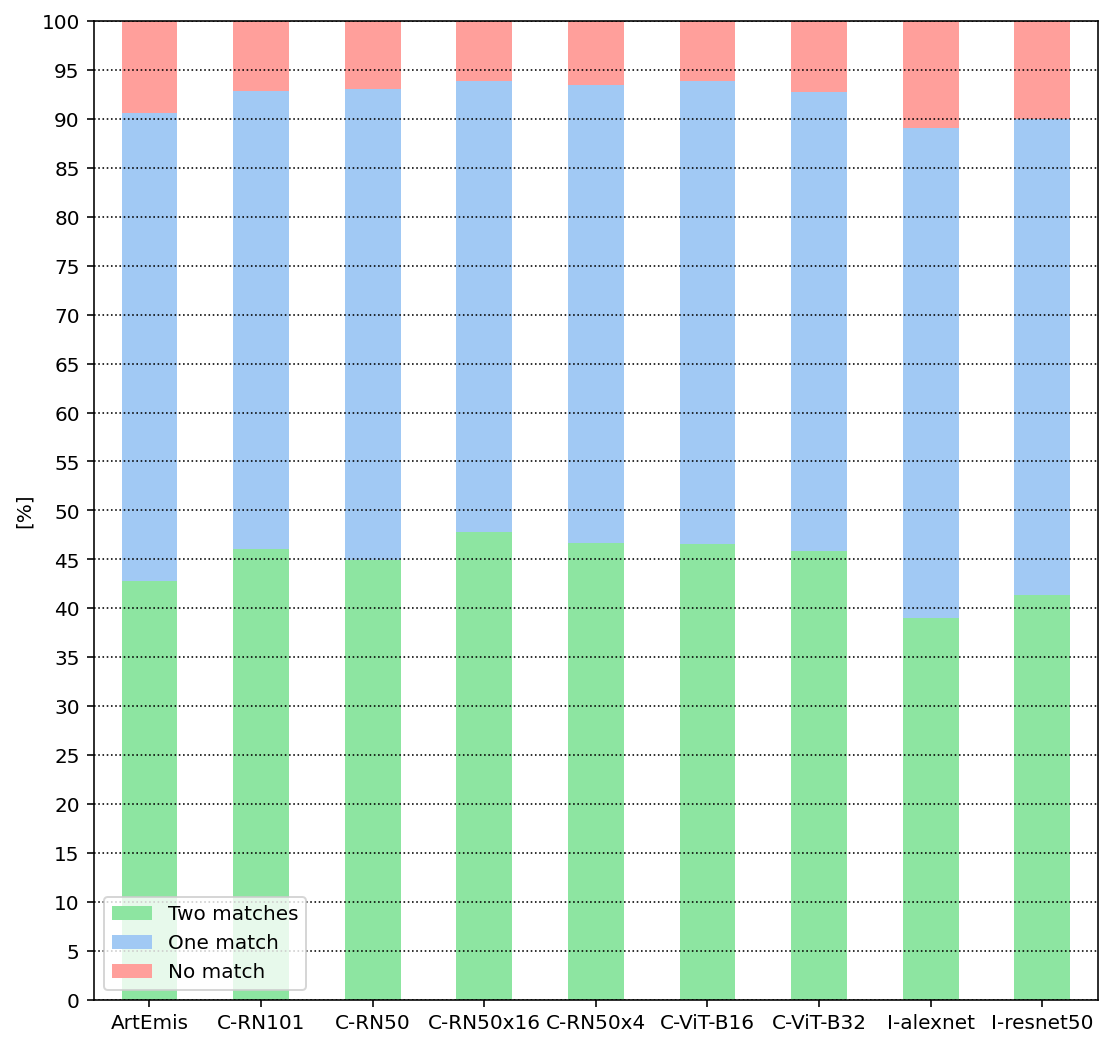

In [277]:
p = sns.color_palette("pastel")
axs = top2s[keys_ordered].T[[2,1,0]].plot.bar(stacked = True,
                        figsize=(9,9),
                        color= [p[2], p[0], p[3]],
                       #hatch = True,

                       )

plt.grid(axis= "y", ls = ":", color = "black")
plt.legend(["Two matches", "One match", "No match"])
plt.ylim(0,100)
plt.yticks(range(0,105,5));
plt.xticks(rotation=0)
plt.ylabel("[%]");
#save_fig("../results/figures/top2_small.pdf")

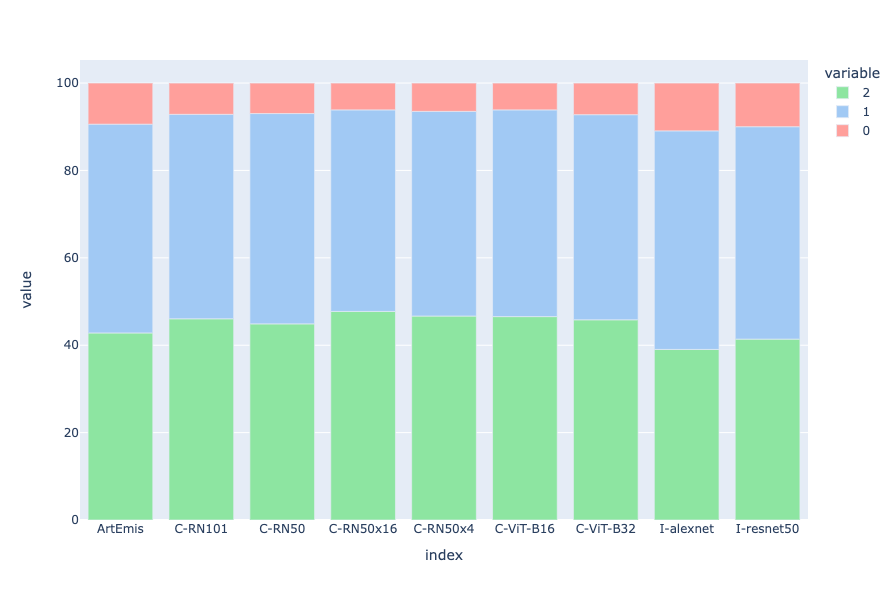

In [276]:
p = sns.color_palette("pastel" )
ppx, _ = px.colors.convert_colors_to_same_type(p)
px.bar(top2s[keys_ordered].T[[2,1,0]],
       color_discrete_sequence=[ppx[2], ppx[0], ppx[3]], height = 600
      )


## Accuracy as a function of annotators' agreement

In [282]:
slps_top1 = pd.DataFrame(index = reports.keys(), columns = np.arange(0, 1.0, 0.05))
for key, slp in tqdm(reports.items()) :
    for thresh in np.arange(0, 1.0, 0.05):
        slps_top1[thresh].loc[key] = results_df_top_n(1,thresh, n_labels=1, report = slp)[0]



100%|██████████| 9/9 [00:48<00:00,  5.43s/it]


In [288]:
slps_plot = slps_top1.applymap(lambda y: y.loc[1])

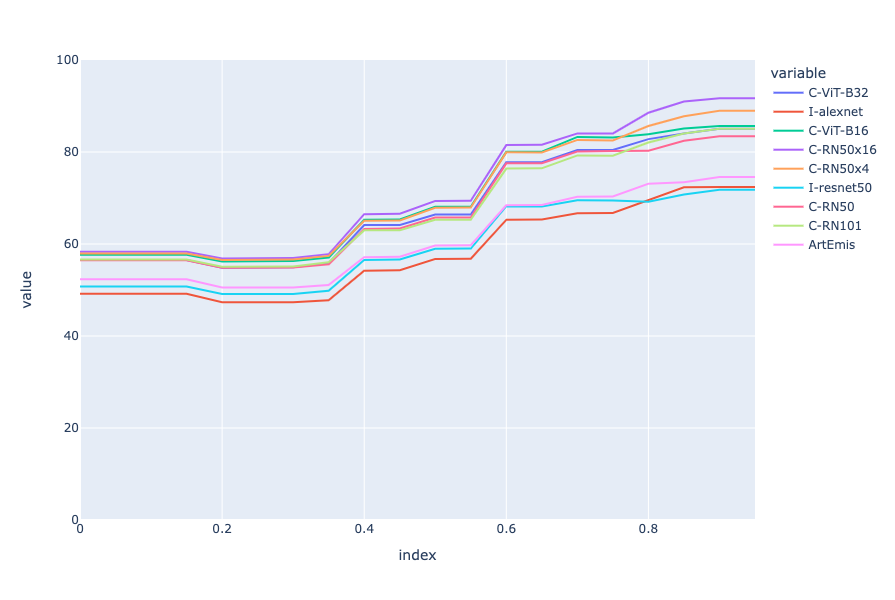

In [292]:
px.line(slps_plot.T, height = 600, range_y = (0,100))

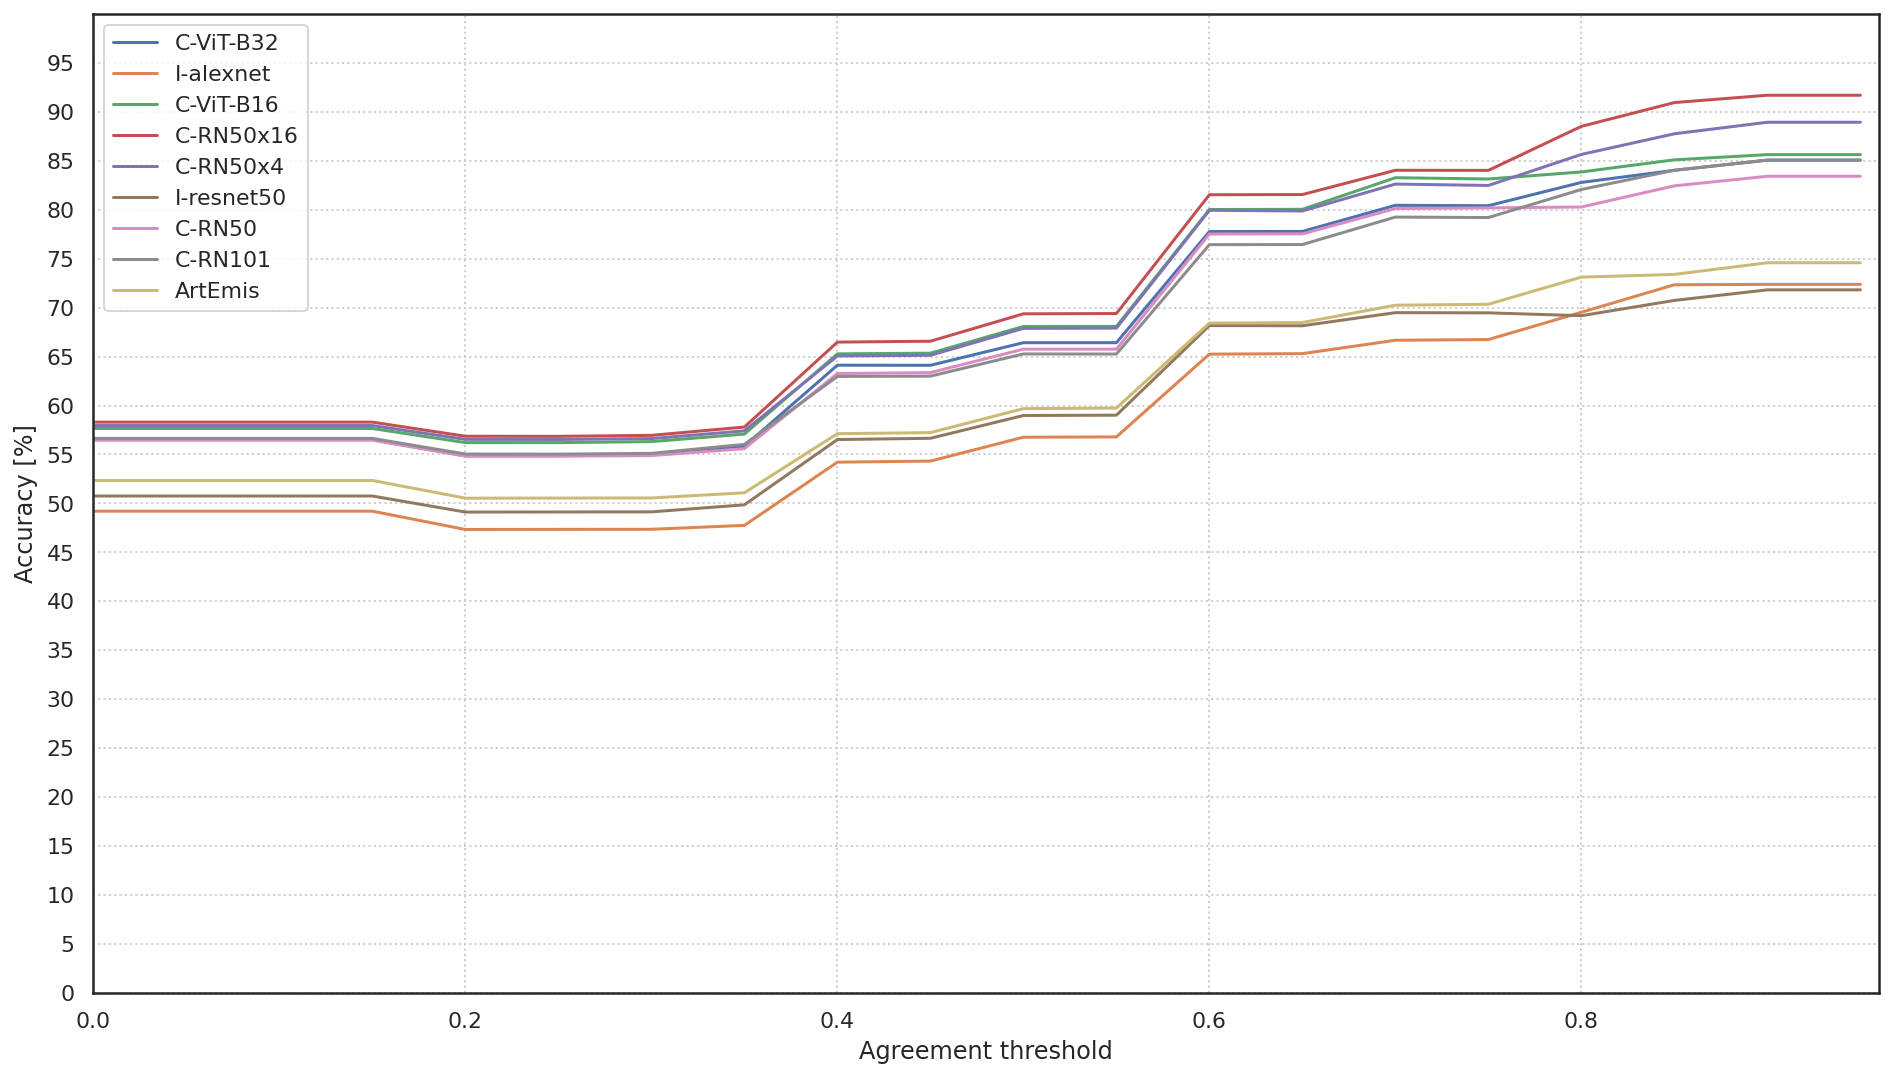

In [285]:
sns.set_theme(context = "notebook", style = "white")
slps_top1.applymap(lambda y :  y.loc[1]).T.plot(figsize = (16,9))
plt.legend()
plt.ylim(0,100)
plt.yticks(range(0,100,5));
plt.xlabel("Agreement threshold")
plt.ylabel("Accuracy [%]")
plt.xlim(0,0.96)
plt.grid(ls = ":")
#save_fig("../results/figures/top1_all.pdf")